In [11]:
# Loding dataset
import pandas as pd

df = pd.read_csv("Resume.csv")

display(df.head())

# Check For Null Values
display(df.isnull().sum())

# If null value is present drop the rows
df.dropna(inplace=True)

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


ID             0
Resume_str     0
Resume_html    0
Category       0
dtype: int64

In [27]:
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Cleaning the dataset
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'[^a-zA-Z/s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_text'] = df['Resume_str'].apply(clean_text)

# Tokenizing and Padding
tokenizer = Tokenizer(num_words = 5000, oov_token = "<OOV>")
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])
padded_sequences = pad_sequences(sequences, maxlen = 200, padding = 'post', truncating = 'post')

# Label Encoding
le = LabelEncoder()
encoded_labels = le.fit_transform(df['Category'])

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Embedding

# Constructing the Gru Model
model = Sequential()
model.add(Embedding(input_dim = 5000, output_dim = 128))
model.add(GRU(units = 64, return_sequences = False))
model.add(Dropout(0.5))
num_class = len(le.classes_)
model.add(Dense(units = num_class, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.9913 - loss: 0.0599 - val_accuracy: 0.1871 - val_loss: 5.7071
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.9895 - loss: 0.0499 - val_accuracy: 0.1932 - val_loss: 5.7260
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.9901 - loss: 0.0526 - val_accuracy: 0.1811 - val_loss: 5.9185
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9759 - loss: 0.1123 - val_accuracy: 0.1992 - val_loss: 5.5138
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.9717 - loss: 0.1318 - val_accuracy: 0.1791 - val_loss: 5.5814
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.9841 - loss: 0.0692 - val_accuracy: 0.1831 - val_loss: 5.7366
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.9912 - loss: 0.0498 - val_accuracy: 0.1891 - val_loss: 5.8314
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.9912 - loss: 0.0496 - val_accuracy:

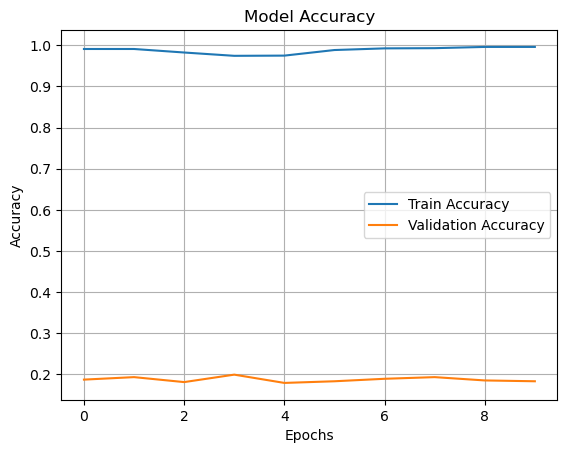

In [69]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

num_classes = len(set(encoded_labels))
encoded_labels_categorical = to_categorical(encoded_labels,num_classes=num_classes)

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels_categorical, test_size = 0.2, random_state = 42)

history = model.fit(X_train, y_train, epochs = 10, batch_size = 32, validation_data = (X_test, y_test), verbose = 1)

plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

In [67]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

y_pred = model.predict(y_test)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true_classes = np.argmax(y_test, axis = 1)

print(f"\nConfusion Matrix: {confusion_matrix(y_true_classes, y_pred_classes)}")
print(f"\nClassification Report: {classification_report(y_true_classes, y_pred_classes, target_names = le.classes_)}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.1719 - loss: 5.6744
Test Accuracy: 0.1831
Test Loss: 5.6082
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Confusion Matrix: [[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 29  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 30  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  8  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 20  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 18  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 21  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 23  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 27  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 24  0]
 [ 

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
